Import the Library

In [ ]:
import argparse
import os, torch

import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split

import wandb
from datetime import datetime

# print(wandb.__version__) ==> Check version of wandb

TitanicDataset
* A custom Dataset class must implement three functions: __ init __, __ len __, and __ getitem __.

In [ ]:
class TitanicDataset(Dataset):
    def __init__(self, X, y): # X: input, y: target
        self.X = torch.FloatTensor(X) # same as torch.Tensor(X)
        self.y = torch.LongTensor(y) # int64 data type value

    def __len__(self):
        return len(self.X) # return the number of samples in dataset

    def __getitem__(self, idx):
        feature = self.X[idx]
        target = self.y[idx]
        return {'input': feature, 'target': target} # load and return a sample from the dataset at the idx

    def __str__(self):
        str = "Data size: {0}, Input Shape: {1}, Target Shape:{2}".format(len(self.X), self.X.shape, self.y.shape)
        return str

TitanicTestDataset

In [ ]:
class TitanicTestDataset(Dataset):
    def __init__(self, X):
        self.X = torch.FloatTensor(X) # same as torch.Tensor(X)

    def __len__(self):
        return len(self.X) # return the number of samples in dataset

    def __getitem__(self, idx):
        feature = self.X[idx]
        return {'input': feature} # load and return a sample from the dataset at the idx

    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}".format(len(self.X), self.X.shape)
        return str

get_preprocessed_dataset

In [ ]:
def get_preprocessed_dataset():
    CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))

    train_data_path = os.path.join(CURRENT_FILE_PATH, "homework_2", "train.csv") # set train data path
    test_data_path = os.path.join(CURRENT_FILE_PATH, "homework_2", "test.csv") # set test data path

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False) # concatenate train_df and test_df in the column direction
    all_df = get_preprocessed_dataset_1(all_df)
    all_df = get_preprocessed_dataset_2(all_df)
    all_df = get_preprocessed_dataset_3(all_df)
    all_df = get_preprocessed_dataset_4(all_df)
    all_df = get_preprocessed_dataset_5(all_df)
    all_df = get_preprocessed_dataset_6(all_df)

    # Create train_X by filtering rows where 'Survived' is not null
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    # Set train_y to the 'Survived' values
    train_y = train_df["Survived"]

    # Create text_X by selecting rows where 'Survived' is null
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    # Create a training dataset using TitanicDataset class
    dataset = TitanicDataset(train_X.values, train_y.values)

    # Split a training dataset into 80% train_dataset and 20% validation_dataset
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    # Create the test dataset
    test_dataset = TitanicTestDataset(test_X.values)

    return train_dataset, validation_dataset, test_dataset

In [ ]:
def get_preprocessed_dataset_1(all_df):
    # Pclass별 Fare 평균값을 사용하여 Fare 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"] # change name of column

    # Merge Fare_mean with all_df based on Pclass
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")

    # Fill null Fare values with Fare_mean
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df

In [ ]:
def get_preprocessed_dataset_2(all_df):
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"] # rename the columns of name_df to values in the list
    name_df["family_name"] = name_df["family_name"].str.strip() # remove leading/trailing spaces
    name_df["honorific"] = name_df["honorific"].str.strip() # remove leading/trailing spaces
    name_df["name"] = name_df["name"].str.strip() # remove leading/trailing spaces
    all_df = pd.concat([all_df, name_df], axis=1) # concatenate all_df and name_df in the column direction

    return all_df

In [ ]:
def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ] # rename the columns of honorific_age_mean to values in the list

    # Merge honorific_age_mean with all_df based on honorific
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")

    # Fill null Age values with honorific_age_mean
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    all_df = all_df.drop(["honorific_age_mean"], axis=1) # drop 'honorific_age_mean' from all_df

    return all_df

In [ ]:
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    # Fill 0 in the 'alone' column
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df

In [ ]:
def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"

    # Fill 'missing' in the 'Embarked' column
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df

In [ ]:
def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    # Identify columns with object data types
    category_features = all_df.columns[all_df.dtypes == "object"]
    from sklearn.preprocessing import LabelEncoder

    # Repeat through each category_features
    for category_feature in category_features:
        le = LabelEncoder() # create a new LabelEncoder instance

        # Check if the feature's data type is object
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature]) # fit the encoder on the data of the current feature
          # Transform the 'category_feature' column in all_df using that determined mapping from the le.fit()
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df

MyModel

In [ ]:
from torch import nn, optim

class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        # Initialize the parent class nn.Module
        super().__init__()

        # Define a sequential model
        self.model = nn.Sequential(
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]), # First layer: input to hidden layer with 30 units
            nn.ReLU(), # Activation function: ReLU
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]), # Second layer: hidden layer to hidden layer with 30 units
            nn.ReLU(), # Activation function: ReLU
            nn.Linear(wandb.config.n_hidden_unit_list[1], n_output), # Third layer : hidden layer to output
        )

    def forward(self, x):
        x = self.model(x) # Pass input through the model
        return x

**get_model_and_optimizer()** from d_my_model_training_with_argparse_wandb.py

In [ ]:
def get_model_and_optimizer():
    # Create an instance of MyModel
    my_model = MyModel(n_input=11, n_output=2)
    # Initialize the SGD optimizer with the model parameters and learning rate from wandb config
    optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)

    return my_model, optimizer

__training_loop()__ from d_my_model_training_with_argparse_wandb.py

In [ ]:
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
    n_epochs = wandb.config.epochs
    loss_fn = nn.CrossEntropyLoss() # use a built-in loss function for Classification problem
    next_print_epoch = 100
    best_val_loss = 1.0
    best_epoch = 0

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0 # initialize training loss
        num_trains = 0 # initialize the number of training batches

        # Iterate through the training data loader
        for train_batch in train_data_loader:
            input, target = train_batch['input'], train_batch['target'] # extract input and target from train_batch
            output_train = model(input) # get training output
            loss = loss_fn(output_train, target) # compute training loss
            loss_train += loss.item() # training loss
            num_trains += 1 # count the number of training batches

            optimizer.zero_grad() # clear gradients from the previous step
            loss.backward() # backward pass to compute gradients
            optimizer.step() # update model parameters

        model.eval() # change model into evaluation mode
        loss_validation = 0.0 # Initialize validation loss
        num_validations = 0 # Initialize the number of validation batches

        # Disable gradient calculation for validation
        with torch.no_grad():
            # Iterate through the validation data loader
            for validation_batch in validation_data_loader:
                input, target = validation_batch['input'], validation_batch['target'] # extract input and target from validation_batch
                output_validation = model(input) # get training output
                loss = loss_fn(output_validation, target) # compute validation loss
                loss_validation += loss.item() # validation loss
                num_validations += 1 # count the number of validation batches

        # Log training and validation loss to wandb
        wandb.log({
            "Epoch": epoch,
            "Training Loss": loss_train / num_trains, # average training loss
            "Validation Loss": loss_validation / num_validations # average validation loss
        })

        # Print training and validation loss every 100 epochs
        if epoch >= next_print_epoch:
            print(
                f"Epoch {epoch}, "
                f"Training Loss: {loss_train / num_trains: .4f}, "
                f"Validation Loss: {loss_validation / num_validations: .4f}"
            )
            next_print_epoch += 100

        # Check the epoch to get the best validation loss
        if loss_validation / num_validations < best_val_loss:
            best_val_loss = loss_validation / num_validations # update best validation loss
            best_epoch = epoch # update the epoch number
            torch.save(model.state_dict(), f'best_model_epoch.pt') # save the model weights

    # Print the best validation loss and epoch
    print(f'Best Validation Loss: {best_val_loss:.4f}, Epoch: {best_epoch}')
    return best_val_loss, best_epoch

**main()** from d_my_model_training_with_argparse_wandb.py

In [ ]:
def main(args):
    # Get the current time as a formatted string for logging
    current_time_str = datetime.now().astimezone().strftime("%Y_%m_%d_%H_%M_%S")

    # Configuration for the training process
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': 1e-3,
        'n_hidden_unit_list': [30, 30],
    }

    # Initialize wandb
    wandb.init(
        mode="online",
        project="homework2",
        notes="Titanic dataset experiment",
        tags=["my_model", "titanic"],
        name=current_time_str,
        config=config
    )

    # Print command line arguments and wandb configuration for reference
    print(args)
    print(wandb.config)

    # Get the model and optimizer
    my_model, optimizer = get_model_and_optimizer()

    # Create DataLoader for training, validation, test datasets
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

    # Start the training loop
    training_loop(
        model=my_model,
        optimizer=optimizer,
        train_data_loader=train_data_loader,
        validation_data_loader=validation_data_loader,
    )

    # Perform testing and get predictions
    indices, predictions = test(test_data_loader)

    # Save the results to a CSV file for submission
    results_df = pd.DataFrame({'PassengerId': indices, 'Survived': predictions})
    results_df.to_csv(f'submission.csv', index=False)

    # Finish wandb
    wandb.finish()

test

In [ ]:
def test(test_data_loader):
    print("[TEST]")
    batch = next(iter(test_data_loader)) # get a batch data from test_data_loader
    print("{0}".format(batch['input'].shape)) # print the shape of the input

    predictions = []
    indices = []

    # Create an instance of MyModel
    my_model = MyModel(n_input=11, n_output=2)
    my_model.load_state_dict(torch.load(f'best_model_epoch.pt'))
    my_model.eval()
    # Get the output by passing the input through the model
    output_batch = my_model(batch['input'])
    # Get the prediction using torch.argmax to find the index of the maximum value in the output
    prediction_batch = torch.argmax(output_batch, dim=1)

    # Print the predictions along with their indices
    for idx, prediction in enumerate(prediction_batch, start=892):
        indices.append(idx)
        predictions.append(prediction.item()) # get the Python number from Tensor
        print(idx, prediction.item())

    return indices, predictions

Get the result

In [ ]:
if __name__ == '__main__':
    train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

    # Parsing the arguments
    parser = argparse.ArgumentParser()

    parser.add_argument("--wandb", action=argparse.BooleanOptionalAction, default=False, help="True or False") # logging option
    parser.add_argument("--batch_size", type=int, default=512, help="Batch size (int, default:512)") # batch size
    parser.add_argument("--epochs", type=int, default=1_000, help="Number of epochs (int, default:1_000)") # training epochs

    args = parser.parse_args('') # important to put '' in Jupyter otherwise it will complain

    main(args)

    # # Print the sizes of the datasets
    # print("train_dataset: {0}, validation_dataset: {1}, test_dataset: {2}".format(len(train_dataset), len(validation_dataset), len(test_dataset)))
    # print("#" * 50, 1)
    #
    # # Print each sample in th training dataset
    # for idx, sample in enumerate(train_dataset):
    #     print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))
    #
    # print("#" * 50, 2)
    #
    # # Print information about training batches
    # print("[TRAIN]")
    # for idx, batch in enumerate(train_data_loader):
    #     print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))
    #
    # # Print information about validation batches
    # print("[VALIDATION]")
    # for idx, batch in enumerate(validation_data_loader):
    #     print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))
    #
    # print("#" * 50, 3)
    #
    # # Print information about test batches
    # print("[TEST]")
    # batch = next(iter(test_data_loader)) # get a batch data from test_data_loader
    # print("{0}".format(batch['input'].shape)) # print the shape of the input
    # my_model = MyModel(n_input=11, n_output=2) # create an instance of MyModel
    # output_batch = my_model(batch['input']) # get the output by passing the input through the model
    # prediction_batch = torch.argmax(output_batch, dim=1)
    # # get the prediction using torch.argmax to find the index of the maximum value in the output
    # for idx, prediction in enumerate(prediction_batch, start=892):
    #     print(idx, prediction.item()) # print the predictions along with their indices

C:\Users\iwawy\AppData\Local\Temp\ipykernel_35212\2958555005.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\iwawy\AppData\Local\Temp\ipykernel_35212\388684495.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
Training Loss,██▇▇▇▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁
Validation Loss,▆█▆▅█▆▅▆▅▄▆▅▅▅▅▄▄▃▃▃▅▅▃▂▄▃▂▄▁▂▅▃▄▂▂▂▂▁▁▁
Epoch,399
Training Loss,0.45914
Validation Loss,0.4741


Namespace(wandb=False, batch_size=512, epochs=1000)
{'epochs': 1000, 'batch_size': 512, 'learning_rate': 0.001, 'n_hidden_unit_list': [30, 30]}
Epoch 100, Training Loss:  0.5601, Validation Loss:  0.5646
Epoch 200, Training Loss:  0.5316, Validation Loss:  0.5302
Epoch 300, Training Loss:  0.5077, Validation Loss:  0.5015
Epoch 400, Training Loss:  0.4970, Validation Loss:  0.4785
Epoch 500, Training Loss:  0.4641, Validation Loss:  0.4446
Epoch 600, Training Loss:  0.4486, Validation Loss:  0.4768
Epoch 700, Training Loss:  0.4292, Validation Loss:  0.4206
Epoch 800, Training Loss:  0.4374, Validation Loss:  0.4242
Epoch 900, Training Loss:  0.4223, Validation Loss:  0.4135
Epoch 1000, Training Loss:  0.4145, Validation Loss:  0.4064
Best Validation Loss: 0.3862, Epoch: 953
[TEST]
torch.Size([418, 11])


C:\Users\iwawy\AppData\Local\Temp\ipykernel_35212\4202016709.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_model.load_state_dict(torch.load(f'best_model_epoch.pt')

892 0
893 0
894 0
895 0
896 1
897 0
898 1
899 0
900 1
901 0
902 0
903 0
904 1
905 0
906 1
907 1
908 0
909 0
910 1
911 1
912 0
913 0
914 1
915 1
916 1
917 0
918 1
919 0
920 0
921 0
922 0
923 0
924 0
925 0
926 1
927 0
928 1
929 1
930 0
931 1
932 0
933 1
934 0
935 1
936 1
937 0
938 0
939 0
940 1
941 1
942 1
943 0
944 1
945 1
946 0
947 0
948 0
949 0
950 0
951 1
952 0
953 0
954 0
955 1
956 1
957 1
958 1
959 0
960 1
961 1
962 1
963 0
964 1
965 1
966 1
967 1
968 0
969 1
970 0
971 1
972 1
973 1
974 0
975 0
976 0
977 0
978 1
979 1
980 1
981 1
982 1
983 0
984 1
985 0
986 1
987 0
988 1
989 0
990 1
991 0
992 1
993 0
994 0
995 0
996 1
997 0
998 0
999 0
1000 0
1001 0
1002 0
1003 1
1004 1
1005 1
1006 1
1007 0
1008 0
1009 1
1010 1
1011 1
1012 1
1013 0
1014 1
1015 0
1016 0
1017 1
1018 0
1019 0
1020 0
1021 0
1022 0
1023 0
1024 0
1025 0
1026 0
1027 0
1028 0
1029 0
1030 1
1031 0
1032 0
1033 1
1034 1
1035 0
1036 1
1037 0
1038 0
1039 0
1040 1
1041 0
1042 1
1043 0
1044 0
1045 1
1046 0
1047 0
1048 1
1049 1
10

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
Training Loss,▇██▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▄▂▃▂▃▂▂▂▃▂▁▂▂▁▁▂▁▁
Validation Loss,▆▅▆▄▄▇▄▄█▄▆▄▃▄▅▄▂▃▃▂▂▃▂▁▂▁▁▁▁▃▃▂▃▂▃▃▂▁▃▁
Epoch,1000
Training Loss,0.41452
Validation Loss,0.40639


# 기술적 사항

Summary of **Pandas**
* pandas.concat(objs, *, axis=0, join='outer', ignore_index=False, keys=None, levels=None, names=None, verify_integrity=False, sort=False, copy=None):
    * Concatenate pandas objects along a particular axis.
    * Allows optional set logic along the other axes.
    * Can also add a layer of hierarchical indexing on the concatenation axis, which may be useful if the labels are the same (or overlapping) on the passed axis number.
* pandas.merge(left, right, how='inner', on=None, left_on=None, right_on=None, left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=None, indicator=False, validate=None):
    * Merge DataFrame or named Series objects with a database-style join.
    * A named Series object is treated as a DataFrame with a single named column.

Summary of **LabelEncoder**<br>le = LabelEncoder()
* le.fit(labels): Learns the unique categories from the input labels and assigns them integer values.
* le.transform(labels): Transforms the input categorical labels into their corresponding numerical values based on the mapping learned during fit().

Summary of **argparse**<br>parser = argparse.ArgumentParser(prog=None, usage=None, description=None, epilog=None, parents=[], formatter_class=argparse.HelpFormatter, prefix_chars='-', fromfile_prefix_chars=None, argument_default=None, conflict_handler='error', add_help=True, allow_abbrev=True, exit_on_error=True):<br>
* prog - The name of the program (default: os.path.basename(sys.argv[0]))
* usage - The string describing the program usage (default: generated from arguments added to parser)
* description - Text to display before the argument help (by default, no text)
* epilog - Text to display after the argument help (by default, no text
* parents - A list of ArgumentParser objects whose arguments should also be included
* formatter_class - A class for customizing the help output
* prefix_chars - The set of characters that prefix optional arguments (default: ‘-‘)
* fromfile_prefix_chars - The set of characters that prefix files from which additional arguments should be read (default: None)
* argument_default - The global default value for arguments (default: None)
* conflict_handler - The strategy for resolving conflicting optionals (usually unnecessary)
* add_help - Add a -h/--help option to the parser (default: True)
* allow_abbrev - Allows long options to be abbreviated if the abbreviation is unambiguous. (default: True)
* exit_on_error - Determines whether or not ArgumentParser exits with error info when an error occurs. (default: True)
* * *
[argparse.ArgumentParser](https://docs.python.org/3/library/argparse.html#argparse.ArgumentParser)

# [숙제 후기]

**Before choosing the activation function, I tried ReLU, ELU, LeakyReLU, Sigmoid, PReLU.**<br>
**ReLU has the smallest validation loss and average train loss at the final epoch.**<br>**That's why I chose ReLU as activation function.**<br>
**I got the validation loss spikes at some epochs but, it is fine as long as validation loss is decreasing overall.**<br>
**Also, I think spikes were due to non-stationary data**
활성화 함수를 선정하기에 앞서 ReLU, ELU, LaeakyReLU, Sigmoid, PReLU를 시도해봤다.<br>
ReLU는 마지막 epoch에서 가장 작은 validation loss와 평균의 train loss를 가지고 있기 때문에 ReLU를 활성화 함수로 선정했다.<br>
validation loss spike를 몇몇 epoch에서 보았는데, validation loss가 계속 줄어들고 있기 때문에 괜찮을 것이라고 생각하였다.<br>
또한, 이는 이례적인 데이터로 인한 것이라 생각하였다.<br>
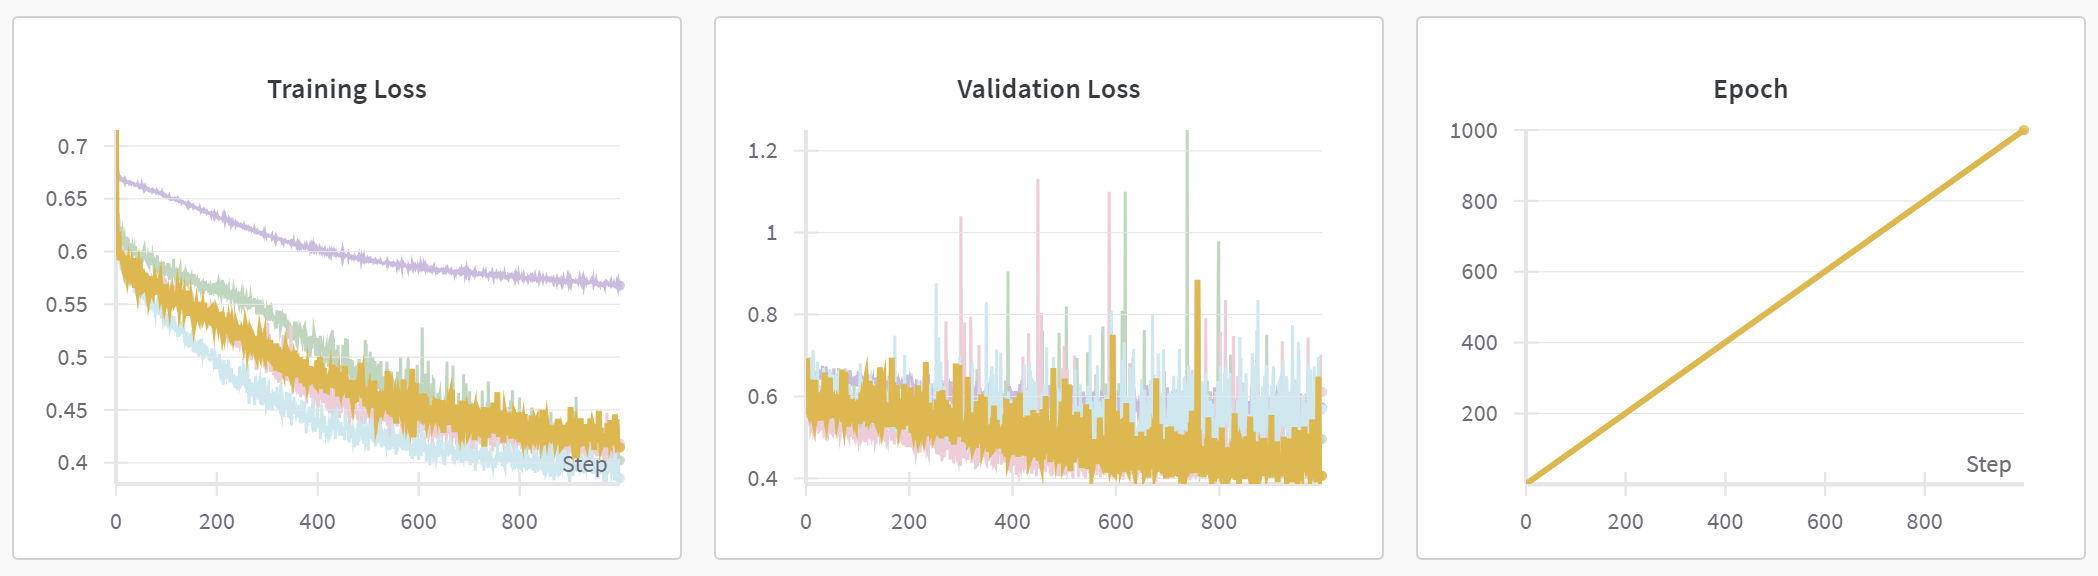

**Rank**<br>
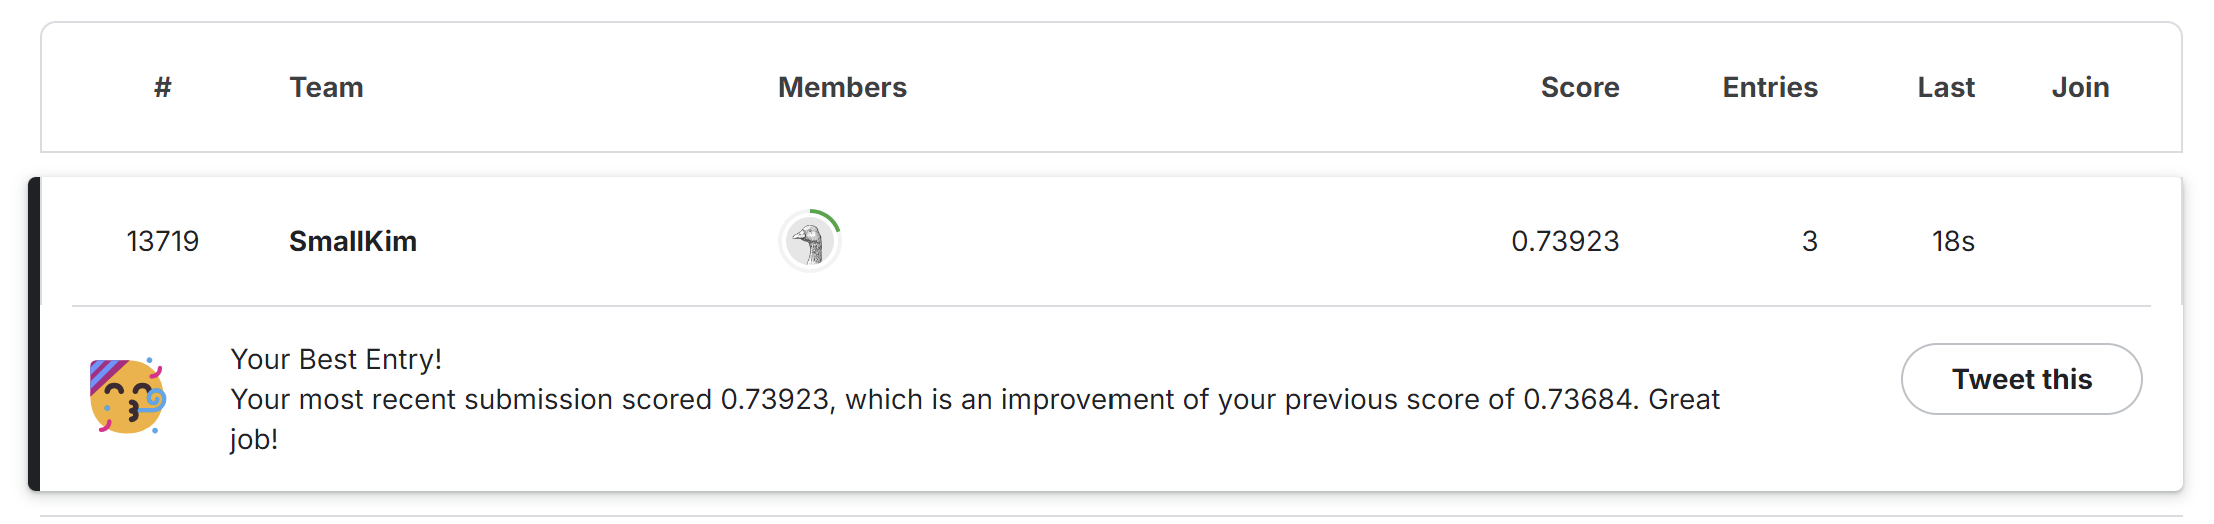